In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fast_ai_exp/mnist_digits/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import os

In [6]:
os.listdir(base_dir)

['sample_submission.csv',
 'test.csv',
 'train.csv',
 'mnist101_stage1.pth',
 'mnist50_stage2.pth',
 'mnist_start.ipynb']

In [0]:
from fastai import *
from fastai.vision import *

In [8]:
df_train = pd.read_csv(base_dir + 'train.csv')
df_train['fn'] = df_train.index
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,fn
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


taken from https://www.kaggle.com/heye0507/fastai-1-0-with-customized-itemlist

In [0]:
class PixelImageItemList(ImageList):
    def open(self,fn):
        regex = re.compile(r'\d+')
        fn = re.findall(regex,fn)
        df = self.inner_df[self.inner_df.fn.values == int(fn[0])]
        df_fn = df[df.fn.values == int(fn[0])]
        img_pixel = df_fn.drop(labels=['label','fn'],axis=1).values
        img_pixel = img_pixel.reshape(28,28)
        img_pixel = np.stack((img_pixel,)*3,axis=-1)
        return vision.Image(pil2tensor(img_pixel,np.float32).div_(255))

In [0]:
data_source = (PixelImageItemList.from_df(df_train, '.', cols='fn').split_by_rand_pct().label_from_df(cols='label'))

In [0]:
tfms = get_transforms(max_rotate=15., max_zoom=1.2, max_lighting=0, max_warp=0, do_flip=False)
data = ImageDataBunch.create_from_ll(data_source, ds_tfms=tfms)

In [12]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 39.0MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 1.74E-02


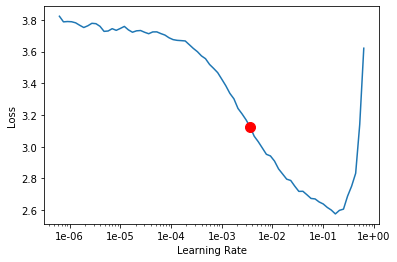

In [13]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_gradient_lrn_rate = learn.recorder.min_grad_lr

In [14]:
learn.fit_one_cycle(6, slice(min_gradient_lrn_rate), wd=.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.964247,0.759222,0.755119,01:17
1,0.400860,0.300153,0.903690,01:18
2,0.218178,0.148549,0.954048,01:17
3,0.163840,0.097332,0.970000,01:17
4,0.131246,0.084164,0.972262,01:17
5,0.116653,0.073845,0.976071,01:17


In [0]:
learn.save(base_dir + 'mnist50_stage1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 6.92E-07


9.120108393559096e-07

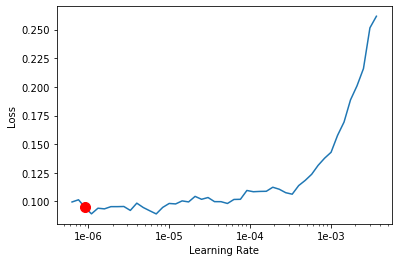

In [16]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_gradient_lrn_rate = learn.recorder.min_grad_lr
min_gradient_lrn_rate

In [17]:
learn.fit_one_cycle(9, slice(2e-3, 1e-4), wd=.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.135756,0.162175,0.949643,01:22
1,0.144339,0.077173,0.978095,01:22
2,0.132450,0.165286,0.963095,01:22
3,0.095902,0.109426,0.964286,01:22
4,0.061449,0.042509,0.987143,01:24
5,0.049140,0.027787,0.990714,01:23
6,0.027379,0.018839,0.994286,01:23
7,0.018977,0.017297,0.994643,01:22
8,0.017708,0.014619,0.995238,01:22


In [0]:
learn.save(base_dir + 'mnist50_stage2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


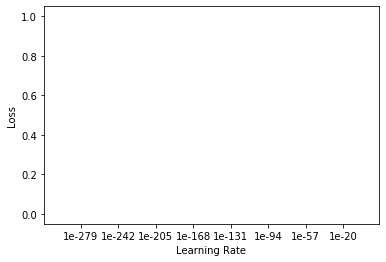

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)


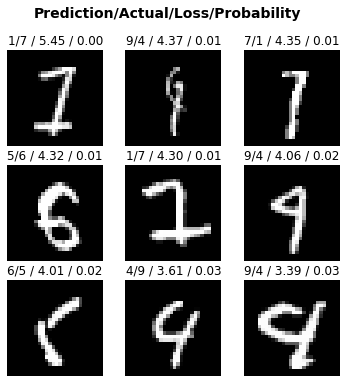

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9,figsize=(6,6))

In [22]:
df_test = pd.read_csv(base_dir + 'test.csv')
df_test['label'] = 0
df_test['fn'] = df_test.index
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label,fn
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [23]:
learn.data.add_test(PixelImageItemList.from_df(df_test, path='.', cols='fn'))
test_pred, test_y, test_loss = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
test_result = torch.argmax(test_pred,dim=1)
result = test_result.numpy()

In [24]:
test_pred.shape

torch.Size([28000, 10])

In [0]:
final = pd.Series(result,name='Label')
submission = pd.concat([pd.Series(range(1,28001),name='ImageId'),final],axis=1)
submission.to_csv(base_dir + 'submission.csv',index=False)

In [26]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
